### Basic Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import time

### Load Data

In [2]:
import pandas as pd

patients = pd.read_csv('internacoes_charlson_zero.csv.gz', compression='gzip', nrows=None)
target = patients['target'].values
patients.shape

(48907, 9)

### Split a Smaller Set

In [3]:
from sklearn.model_selection import StratifiedKFold

split_kfold = StratifiedKFold(n_splits=2)
for trash, used in split_kfold.split(patients.index.values, target):
    break
    
target_set = np.asarray(patients.iloc[used]['target'].values)
text_set = patients.iloc[used]['text'].values

print('Data Size:', len(used))
print('Mean Tokens:', np.mean(patients.iloc[used]['wc'].values))

Data Size: 24459
Mean Tokens: 6043.213418373605


### Load Word2Vec Model

In [4]:
from gensim.models.word2vec import KeyedVectors
w2v_model = KeyedVectors.load_word2vec_format('health_w2v_unigram_150.bin', binary=True)
len(w2v_model.vocab)

67805

### Tokenize Clinical Notes
Remove accents and stopwords, It take a while...

In [5]:
import unicodedata
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

def tokenizer(text):
    return_text = []
    sw_port = stopwords.words("portuguese")
    for sentence in text:
        reg_tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
        tokens = reg_tokenizer.tokenize(sentence)
        return_text.append(' '.join([remove_accents(w.lower()) for w in tokens if w not in sw_port]))
        
    return return_text

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
start = time.time()
tokens_set = tokenizer(text_set)
print('Takes ', round(time.time() - start), ' s for', len(used), ' instances')

Takes  945  s for 24459  instances


### Text Vector Representation

In [7]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

start = time.time()

max_words = len(w2v_model.vocab)
tokenize = Tokenizer(num_words=max_words)
tokenize.fit_on_texts(tokens_set)

max_length = 2000
sequences = tokenize.texts_to_sequences(tokens_set)
data_matrix = pad_sequences(sequences, maxlen=max_length)

print('Takes ', round(time.time() - start), ' s for', len(used), ' instances')

Using TensorFlow backend.


Takes  204  s for 24459  instances


In [8]:
len(data_matrix[0][data_matrix[0]!=0]), len(tokens_set[0])

(322, 2173)

### Setup Words Weights for Embedding Layer

In [9]:
vocab_dim = len(w2v_model.word_vec('0'))
word_index = tokenize.word_index
n_symbols = min(max_words, len(word_index))+1

embedding_weights = np.zeros((n_symbols, vocab_dim))
for word, i in word_index.items():
    if i >= n_symbols: break
    if word in w2v_model.vocab:
        embedding_weights[i] = w2v_model.word_vec(word)

print('Symbols', n_symbols)
print('Weights', embedding_weights.shape)

Symbols 67806
Weights (67806, 150)


### Setup RNN Layers

In [10]:
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Conv1D, Bidirectional, Flatten, MaxPooling1D, Dropout
from keras.layers.embeddings import Embedding
from keras.models import Sequential

conv_0 = Conv1D(50, 3, activation='relu', name='conv0')

lstm_0 = LSTM(units=50, recurrent_activation="hard_sigmoid", activation="sigmoid", name='lstm0')

bi_lstm_0 = Bidirectional(lstm_0, name='bilstm0')

embedding_layer = Embedding(embedding_weights.shape[0],
                            embedding_weights.shape[1],
                            weights=[embedding_weights],
                            input_length=max_length)

### Create Model, Train and Evaluate

In [23]:
print ('Defining a RNN Model...')
   
kfold = StratifiedKFold(n_splits=6)
cvscores = []
times = []

values = []
prediction = []

print('Data Shape', data_matrix.shape)
print('Weights', embedding_weights.shape)

for i, (train, test) in enumerate(kfold.split(data_matrix, target_set)):
    
    #if i > 3: break
    
    start = time.time()
    print('Creating model...')
    # create model
    model = Sequential()
    model.add(embedding_layer)
    
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    
    #model.add(conv_0)
    #model.add(lstm_0)
    #model.add(bi_lstm_0)
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))    
    model.add(Dense(1))
    model.add(Activation('relu'))
    
    # Compile model
    model.compile(loss='mean_absolute_error', optimizer='sgd',metrics=['mae'])
    
    # Fit the model
    model.fit(data_matrix[train], target_set[train], epochs=20, batch_size=100, verbose=1)

    # evaluate the model
    scores = model.evaluate(data_matrix[test], target_set[test], verbose=0)
    target_pred = model.predict(data_matrix[test])
    
    values.extend(target_set[test])
    prediction.extend(np.asarray(target_pred).reshape(len(target_pred)))
    
    print(model.metrics_names[1], scores[1])
    cvscores.append(scores[1])
    times.append(time.time() - start)

# Time / Epoch  |  (2251, 1000)
# - Flat = 2s
# - LSTM = 120s
# - BiLSTM = 120s
# - CONV = 5s

# Flatten, Data 2K = 8s
# Flatten, Data 5K = 12s

# Conv1D, Data  2K = 15s
# Conv1D, Data  5K = 26s

# RandomForestRegressor (2452, 2000) = 1.6523, 1.9503
# RandomForestRegressor (2452, 5000) = 1.5573, 4.6613

print('Mean: ', np.mean(cvscores), 'Std: ', np.std(cvscores))
print('Time: ', np.mean(times))

Defining a RNN Model...
Data Shape (24459, 2000)
Weights (67806, 150)
Creating model...
Epoch 1/20
20372/20372 [==============================] - 542s 27ms/step - loss: 2.3233 - mean_absolute_error: 2.3233
Epoch 2/20
20372/20372 [==============================] - 542s 27ms/step - loss: 2.0426 - mean_absolute_error: 2.0426
Epoch 3/20
20372/20372 [==============================] - 543s 27ms/step - loss: 1.7415 - mean_absolute_error: 1.7415
Epoch 4/20
20372/20372 [==============================] - 543s 27ms/step - loss: 1.6083 - mean_absolute_error: 1.6083
Epoch 5/20
20372/20372 [==============================] - 543s 27ms/step - loss: 1.5515 - mean_absolute_error: 1.5515
Epoch 6/20
20372/20372 [==============================] - 543s 27ms/step - loss: 1.5116 - mean_absolute_error: 1.5116
Epoch 7/20
20372/20372 [==============================] - 543s 27ms/step - loss: 1.4932 - mean_absolute_error: 1.4932
Epoch 8/20
20372/20372 [==============================] - 543s 27ms/step - loss: 1.451

Epoch 8/20
20385/20385 [==============================] - 544s 27ms/step - loss: 1.3054 - mean_absolute_error: 1.3054
Epoch 9/20
20385/20385 [==============================] - 543s 27ms/step - loss: 1.2853 - mean_absolute_error: 1.2853
Epoch 10/20
20385/20385 [==============================] - 543s 27ms/step - loss: 1.2766 - mean_absolute_error: 1.2766
Epoch 11/20
20385/20385 [==============================] - 543s 27ms/step - loss: 1.2703 - mean_absolute_error: 1.2703
Epoch 12/20
20385/20385 [==============================] - 543s 27ms/step - loss: 1.2421 - mean_absolute_error: 1.2421
Epoch 13/20
20385/20385 [==============================] - 543s 27ms/step - loss: 1.2442 - mean_absolute_error: 1.2442
Epoch 14/20
20385/20385 [==============================] - 543s 27ms/step - loss: 1.2315 - mean_absolute_error: 1.2315
Epoch 15/20
20385/20385 [==============================] - 543s 27ms/step - loss: 1.2151 - mean_absolute_error: 1.2151
Epoch 16/20
20385/20385 [=========================

In [24]:
tuples = np.stack((values,np.round(prediction,1)), axis=-1) ## ROUND TUPLES

frequencies = {}
for x,y in tuples:
    key = (x, y)
    if key in frequencies:
        frequencies[key] += 1
    else:
        frequencies[key] = 1

size = []
x = []
y = []
for key in frequencies.keys():
    size.append(frequencies[key])
    x.append(key[0])
    y.append(key[1])

In [28]:
import gzip, pickle

with gzip.open("tuples_conv.npy.gz", "wb") as wfp:   #Pickling
    pickle.dump(tuples, wfp)
    wfp.close()

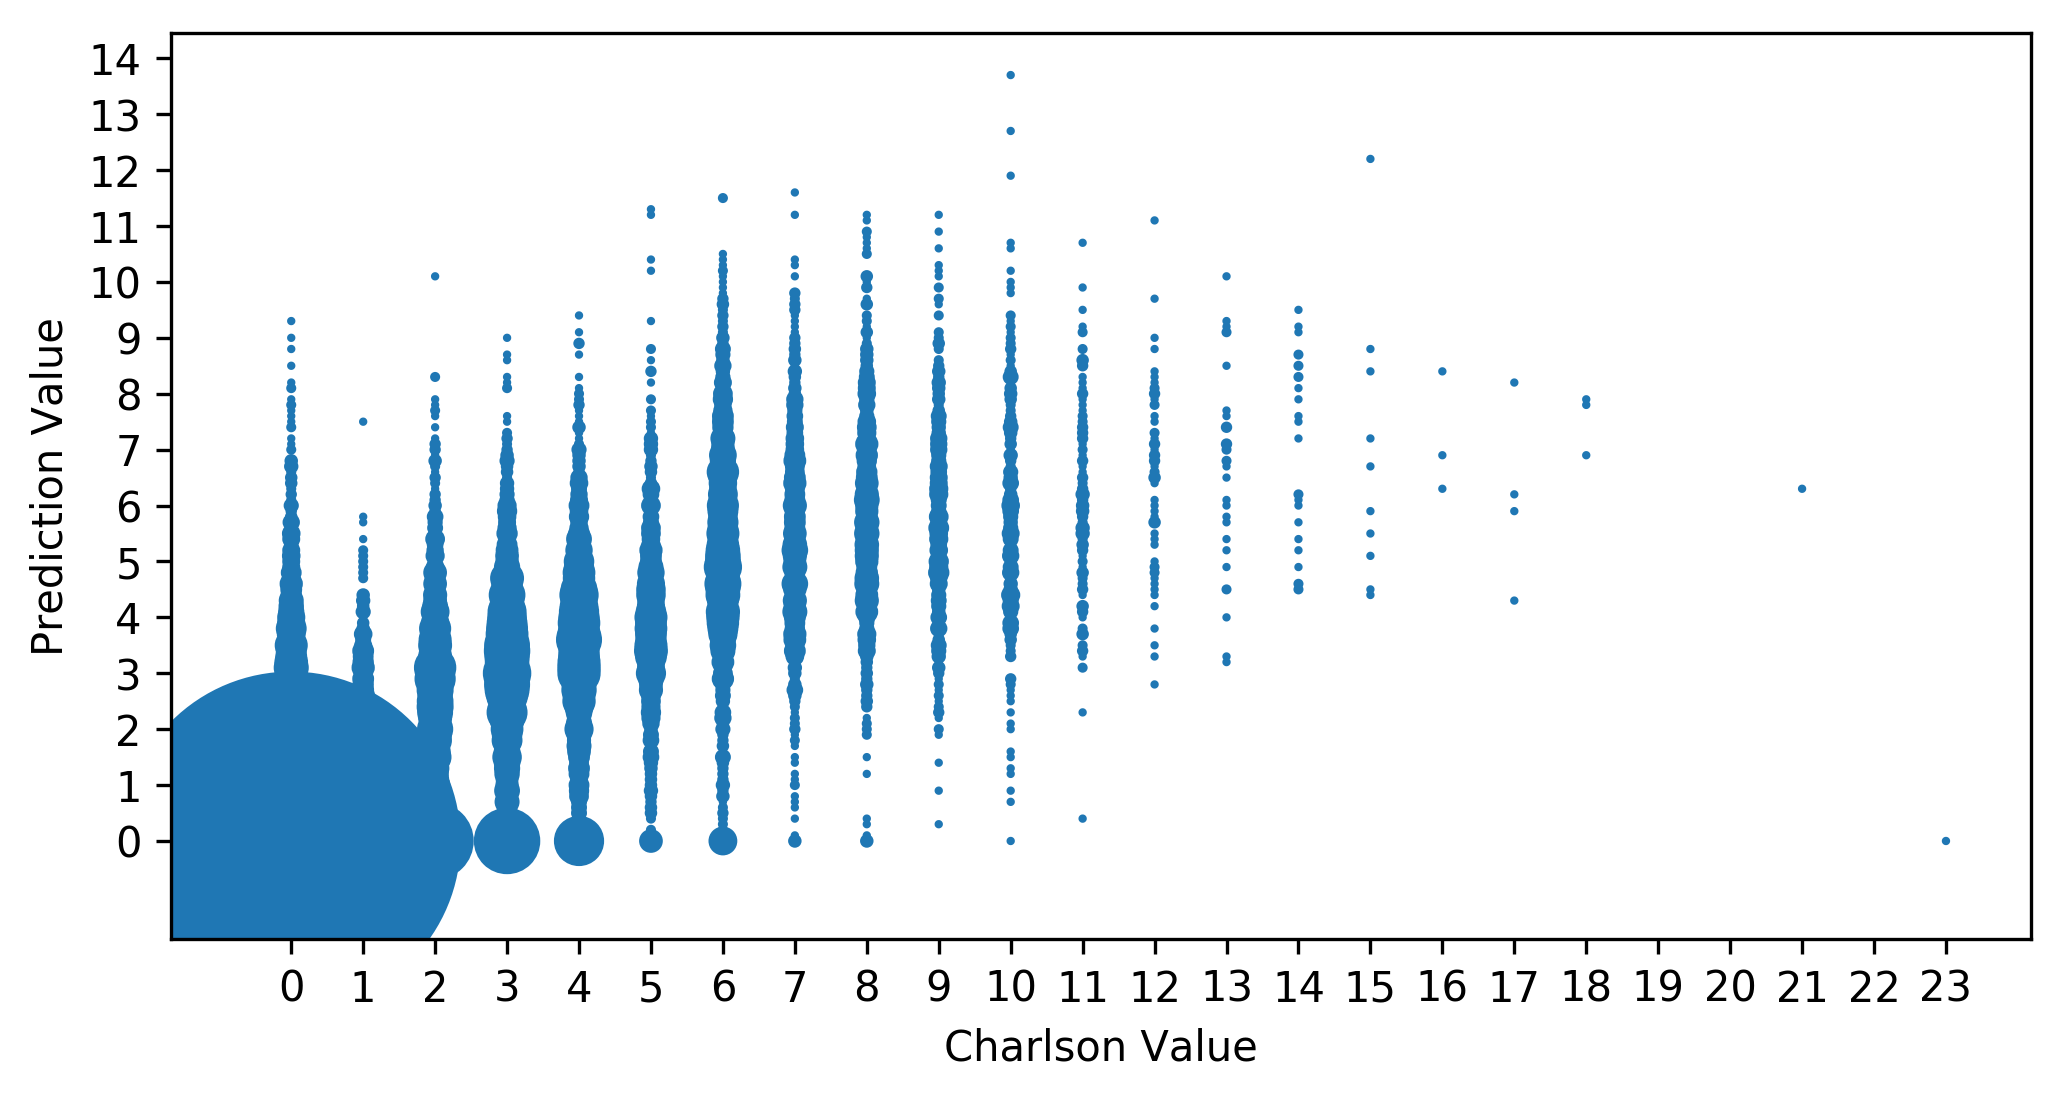

In [25]:
# https://matplotlib.org/gallery/shapes_and_collections/scatter.html
%matplotlib inline
import matplotlib.pyplot as plt

maxX = np.max(x)

plt.figure(figsize=(8, 4), dpi= 300)
plt.xlabel('Charlson Value', fontsize=10)
plt.ylabel('Prediction Value', fontsize=10)
plt.xticks(range(int(maxX)+1))
plt.yticks(range(int(maxX)+1))

plt.scatter(x,y,s=size)
plt.show()

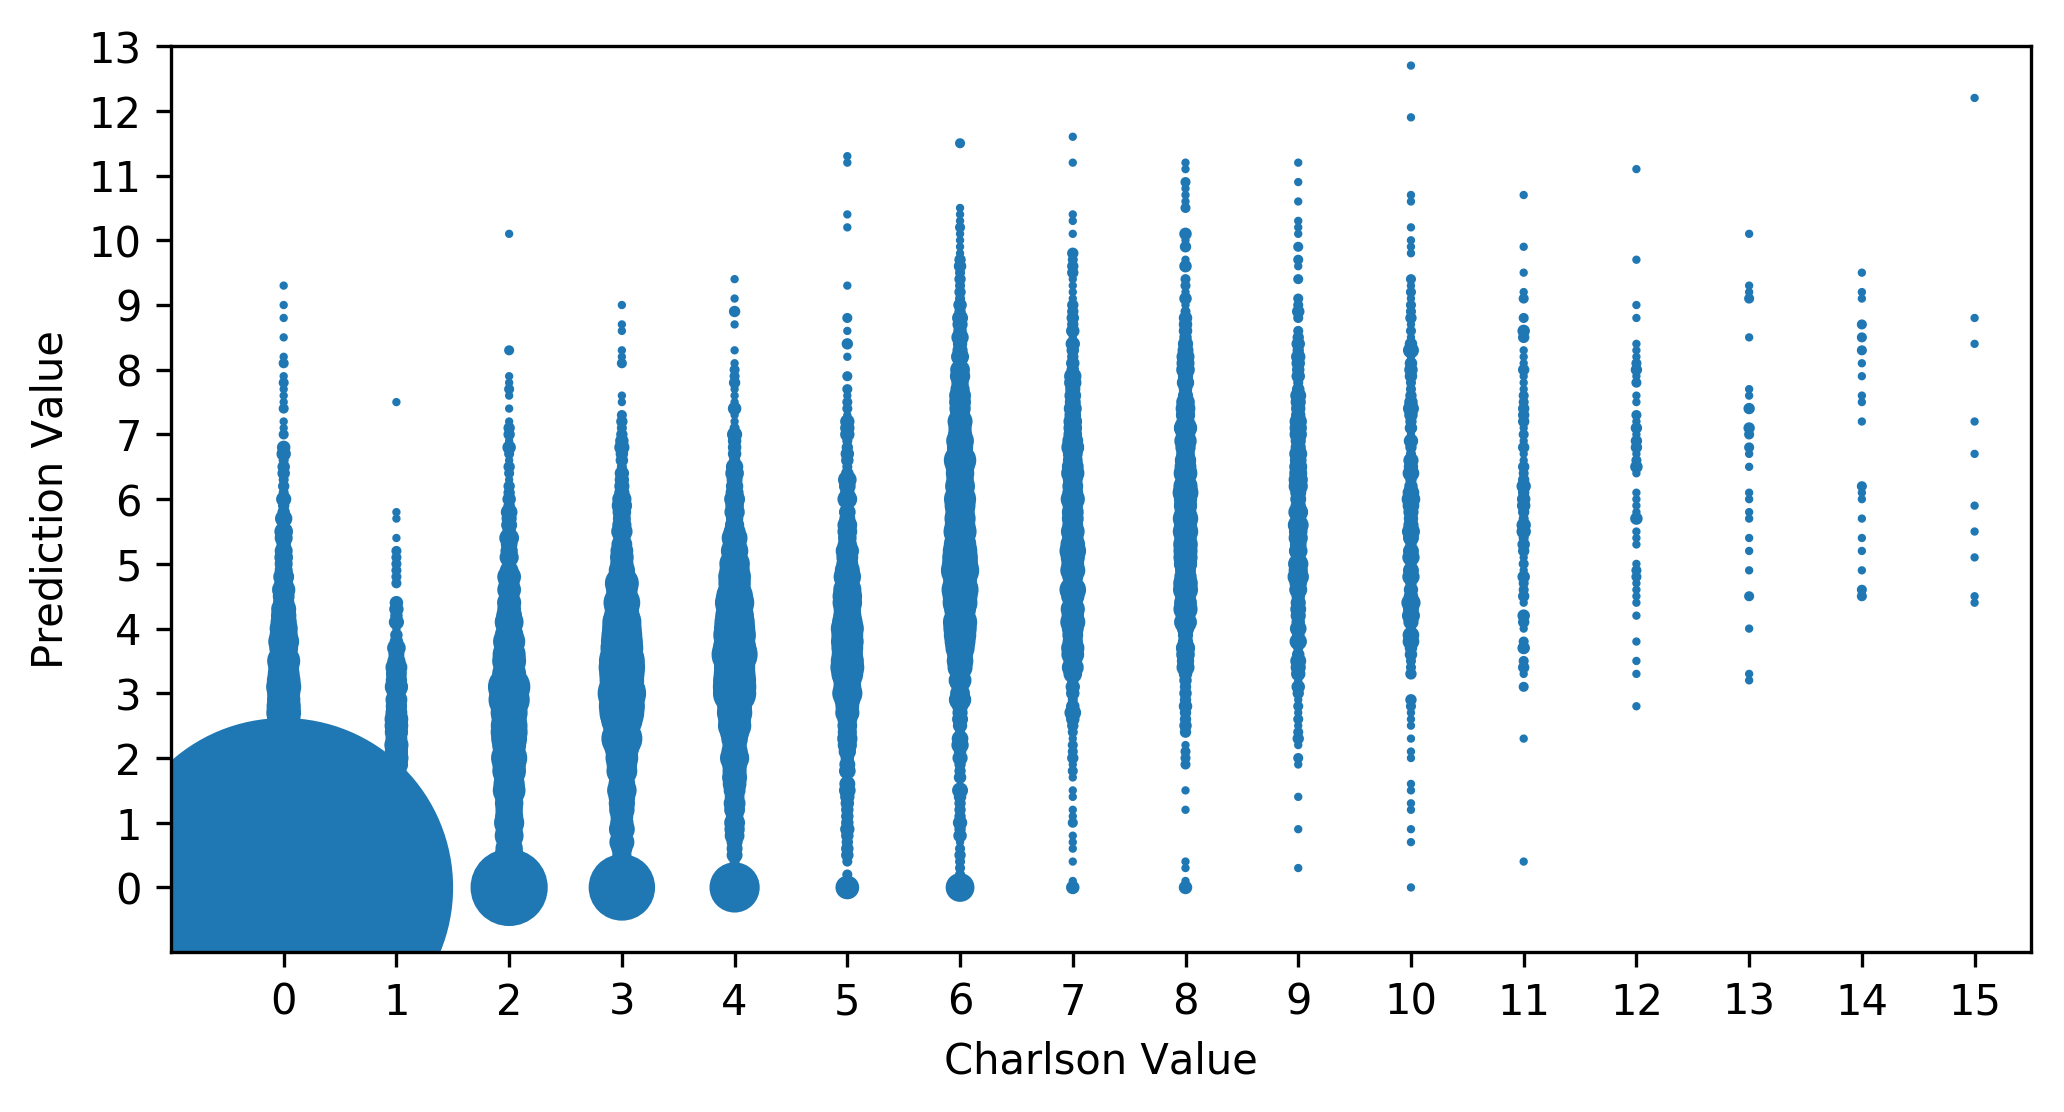

In [36]:
plt.figure(figsize=(8, 4), dpi= 300)
plt.xlabel('Charlson Value', fontsize=10)
plt.ylabel('Prediction Value', fontsize=10)
plt.xticks(range(int(maxX)+1))
plt.yticks(range(int(maxX)+1))
plt.ylim(-1,13)
plt.xlim(-1,15.5)

plt.scatter(x,y,s=size)
plt.show()